<a href="https://colab.research.google.com/github/Rdeandres/fight-churn/blob/master/Game_Analytics_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Statistical modelling
As players can purchase items in this game, it is interesting trying to predict whether a player will spend money in the game or not.




1.   Build features from the dataset
2.   Apply a statistical model of your choice to classify low spenders and high spenders 
3.   Explore model efficiency and accuracy (and other metrics you find appropriate)


In [ ]:
#if using Google colab necesarry to upload requirements file into Google drive
!pip install -r requirements.txt

# package intallation

In [ ]:
import boto
import pandas as pd
import seaborn as sns

# Simmple Data Audits on File

In [48]:
regions = pd.read_csv('https://ga-recruitment.s3.amazonaws.com/data/regions.csv')
events = pd.read_csv('https://ga-recruitment.s3.amazonaws.com/data/assignment_data.csv')

In [236]:
regions.head()

,country_code,name,region
0,xx,Unknown,Unknown
1,a1,Anonymous Proxy,Proxy
2,a2,Satellite Provider,Satellite
3,af,Afghanistan,AsiaPacific
4,al,Albania,Europe


In [11]:
events.head()

,event_timestamp,event_category,event_id,player_country_code,player_id,player_session_id,transaction_amount,game_build,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue
0,1484053435,design,boot,TR,7a98917fd12ba24ae4d2e42a74b0944c,01l7esFo-5XvS-eyKl-QX5q-UalaTmyM2qz,NaN,v1.1.26,1483818916,1484053428,310,NaN
1,1484416837,design,boot,IT,20fbf618e34215d876965b6304134ce3,03PPdJ8G-Hn6V-5zwl-xRZx-3k06wnFhxqH,NaN,v1.1.26,1484416849,1484416835,14,NaN
2,1484148932,design,boot,NaN,c44c05baf6f019241780cca1947e8cc2,03qZsL5V-m8MH-ybBT-PX6w-K83AOfIWnek,NaN,v1.1.28,1482771340,1484148925,8783,NaN
3,1483688749,design,boot,AU,f3c00d6b906806ed9c72ec9d64f5b588,06M0sv0U-05L2-PmtM-UH2M-EiWuzuKM8s0,NaN,v1.1.26,1483354323,1483688742,247,396.0
4,1484148728,design,boot,IN,3cb0e101b67cfcba4fe42b6342e4d3e5,07PnSNdP-pH1B-JD5T-6esH-AjEDbsHNyuZ,NaN,v1.1.26,1482500265,1484148720,178,NaN


In [12]:
events.describe()

,event_timestamp,transaction_amount,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue
count,8.500090e+05,22089.000000,8.500090e+05,8.500090e+05,8.500090e+05,5.999800e+04
mean,1.484032e+09,7182.014668,1.479805e+09,1.484032e+09,5.324387e+03,1.175817e+05
std,2.425812e+05,3685.554366,1.093975e+07,2.428329e+05,4.876150e+04,3.164101e+05
min,1.483574e+09,99.000000,1.424905e+09,1.483230e+09,0.000000e+00,9.900000e+01
25%,1.483829e+09,3699.000000,1.482266e+09,1.483828e+09,1.270000e+02,5.950000e+02
50%,1.484041e+09,9999.000000,1.483610e+09,1.484040e+09,3.010000e+02,3.694000e+03
75%,1.484241e+09,9999.000000,1.483924e+09,1.484241e+09,8.860000e+02,8.999100e+04
max,1.484438e+09,9999.000000,1.484438e+09,1.484438e+09,2.295068e+06,7.247265e+06


In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850009 entries, 0 to 850008
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   event_timestamp                 850009 non-null  int64  
 1   event_category                  850009 non-null  object 
 2   event_id                        850009 non-null  object 
 3   player_country_code             818574 non-null  object 
 4   player_id                       850009 non-null  object 
 5   player_session_id               850009 non-null  object 
 6   transaction_amount              22089 non-null   float64
 7   game_build                      850009 non-null  object 
 8   player_first_install_timestamp  850009 non-null  int64  
 9   session_start_ts                850009 non-null  int64  
 10  session_duration_seconds        850009 non-null  int64  
 11  player_cumulative_revenue       59998 non-null   float64
dtypes: float64(2), i

 each line ia an event, can there be several events per session?
 events of this period 2017-01-05 to 2017-01-14

In [87]:
verif=events.groupby('event_timestamp').player_session_id.nunique()
verif.head()

event_timestamp
1483574400    1
1483574401    1
1483574403    1
1483574404    1
1483574405    1
Name: player_session_id, dtype: int64

For the purposes of this model only clients that have done a transaction interest us
->  clean the rows without transactions(Since no transactions are negative)

In [65]:
clean_sales=events[events.transaction_amount>0]
print(clean_sales.shape)
x=22089/850009 
print(x)
#only 2% of the data is filled in

(22089, 12)
0.025986783669349384


In [238]:
clean_sales.describe(include='all')

,event_timestamp,event_category,event_id,player_country_code,player_id,player_session_id,transaction_amount,game_build,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue,paying_interactions
count,2.208900e+04,22089,22089,21077,22089,22089,22089.000000,22089,2.208900e+04,2.208900e+04,2.208900e+04,2.208900e+04,22089.0
unique,NaN,1,29,75,1826,3461,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,business,Monetize:Buy:buycandy6,US,9ac1eb6f50885e26a22e6e1a6a48729c,Q2GF8bf5-MKiF-5cxW-rzns-AY47gJo7wdY,NaN,v1.1.26,NaN,NaN,NaN,NaN,NaN
freq,NaN,22089,7854,4209,479,187,NaN,21702,NaN,NaN,NaN,NaN,NaN
mean,1.484013e+09,NaN,NaN,NaN,NaN,NaN,7182.014668,NaN,1.480884e+09,1.484012e+09,6.333731e+03,2.671307e+05,1.0
std,2.406987e+05,NaN,NaN,NaN,NaN,NaN,3685.554366,NaN,1.041070e+07,2.406721e+05,3.569231e+04,4.463343e+05,0.0
min,1.483574e+09,NaN,NaN,NaN,NaN,NaN,99.000000,NaN,1.425103e+09,1.483574e+09,0.000000e+00,9.900000e+01,1.0
25%,1.483832e+09,NaN,NaN,NaN,NaN,NaN,3699.000000,NaN,1.483592e+09,1.483831e+09,5.250000e+02,3.999600e+04,1.0
50%,1.483989e+09,NaN,NaN,NaN,NaN,NaN,9999.000000,NaN,1.483854e+09,1.483988e+09,1.182000e+03,1.099890e+05,1.0
75%,1.484214e+09,NaN,NaN,NaN,NaN,NaN,9999.000000,NaN,1.484111e+09,1.484213e+09,2.380000e+03,2.774700e+05,1.0


In [21]:
events.describe(include='all')

,event_timestamp,event_category,event_id,player_country_code,player_id,player_session_id,transaction_amount,game_build,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue
count,8.500090e+05,850009,850009,850009,850009,850009,850009.000000,850009,8.500090e+05,8.500090e+05,8.500090e+05,8.500090e+05
unique,NaN,2,30,161,93175,787548,NaN,2,NaN,NaN,NaN,NaN
top,NaN,design,boot,US,a72cb31fc78b0aba051d8e6744bfdc6a,Q2GF8bf5-MKiF-5cxW-rzns-AY47gJo7wdY,NaN,v1.1.26,NaN,NaN,NaN,NaN
freq,NaN,827920,827920,190732,952,188,NaN,782872,NaN,NaN,NaN,NaN
mean,1.484032e+09,NaN,NaN,NaN,NaN,NaN,186.637461,NaN,1.479805e+09,1.484032e+09,5.324387e+03,8.299523e+03
std,2.425812e+05,NaN,NaN,NaN,NaN,NaN,1287.855574,NaN,1.093975e+07,2.428329e+05,4.876150e+04,8.929468e+04
min,1.483574e+09,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.424905e+09,1.483230e+09,0.000000e+00,0.000000e+00
25%,1.483829e+09,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.482266e+09,1.483828e+09,1.270000e+02,0.000000e+00
50%,1.484041e+09,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.483610e+09,1.484040e+09,3.010000e+02,0.000000e+00
75%,1.484241e+09,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.483924e+09,1.484241e+09,8.860000e+02,0.000000e+00


# Feature engineering: Aggregating data to player level 

In [68]:
# All player interactions in the period 
agg_events_quanti=events[["session_duration_seconds","transaction_amount"]].groupby(events['player_id']).mean()
agg_events_quanti.head()

,session_duration_seconds,transaction_amount
player_id,,
00001dd15ef0d42a1ef636bc387a7f80,101.571429,NaN
000043d11f529189af1e1b86e0600726,10872.076923,NaN
00020a4bd3a628f62a92fe77986ffbb0,76.000000,NaN
00040b31d1f68962fa0c1b61dde20798,26767.666667,NaN
0004db76de003ef8dc7d25bc6cf85124,2612.979167,NaN


Only on paying Events "Paying customers":
Creating aggregate values on player level

In [149]:
#Dates
paying_events = clean_sales

#
agg_events_quali=paying_events[["event_timestamp","player_first_install_timestamp"]].groupby(events['player_id']).min()
agg_events_quali_max=paying_events[["event_timestamp"]].groupby(events['player_id']).max()

# Or rename the existing DataFrame (rather than creating a copy) 
agg_events_quali.rename(columns={'event_timestamp': 'old_transaction_DATE',  'player_first_install_timestamp': 'first_install_DATE'}, inplace=True)
agg_events_quali_max.rename(columns={'event_timestamp': 'recent_transaction_DATE'}, inplace=True)

#merge I'm assuming that all players have the first install completed
player_dates=pd.merge(agg_events_quali,agg_events_quali_max,on='player_id',how='left')
player_dates.head()

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE
player_id,,,
0006fc5ec54e856d83762cccaddbeb37,1483575932,1483575203,1483575983
001d6c0b2a035550a3961ffa4e0b2db7,1484404725,1484404697,1484408114
004375c61ee37f3c813738e340c84a90,1484066761,1483874489,1484066761
004c939c764359818e79cf038e01f927,1483997513,1483996989,1483999320
00523c6b5e1a43d04d217868058ca589,1484157651,1484147127,1484157721


Avg Session Stats per player

In [150]:
#on paying events, min and max per player
agg_paying_events_quanti=paying_events[["session_duration_seconds","transaction_amount"]].groupby(events['player_id']).mean()
# Or rename the existing DataFrame (rather than creating a copy) 
agg_paying_events_quanti.rename(columns={'session_duration_seconds': 'avg-paying-session_Seconds', 'transaction_amount': 'avg-session_Amount' }, inplace=True)
agg_paying_events_quanti.head()

,avg-paying-session_Seconds,avg-session_Amount
player_id,,
0006fc5ec54e856d83762cccaddbeb37,199.000000,9999.000000
001d6c0b2a035550a3961ffa4e0b2db7,1905.290323,5518.354839
004375c61ee37f3c813738e340c84a90,96397.000000,999.000000
004c939c764359818e79cf038e01f927,2264.200000,9999.000000
00523c6b5e1a43d04d217868058ca589,268.000000,7239.000000


In [151]:
player_dates=pd.merge(player_dates,agg_paying_events_quanti,on='player_id',how='left')
player_dates.head()

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE,avg-paying-session_Seconds,avg-session_Amount
player_id,,,,,
0006fc5ec54e856d83762cccaddbeb37,1483575932,1483575203,1483575983,199.000000,9999.000000
001d6c0b2a035550a3961ffa4e0b2db7,1484404725,1484404697,1484408114,1905.290323,5518.354839
004375c61ee37f3c813738e340c84a90,1484066761,1483874489,1484066761,96397.000000,999.000000
004c939c764359818e79cf038e01f927,1483997513,1483996989,1483999320,2264.200000,9999.000000
00523c6b5e1a43d04d217868058ca589,1484157651,1484147127,1484157721,268.000000,7239.000000


In [ ]:
#need to add tot CA and nb of interactions paying or not
#tot CA
Tot_CA_player=paying_events[["player_cumulative_revenue"]].groupby(events['player_id']).max()


#nb and  duration of tot interactions (paying or not)
events["interactions"] = 1

Interaction_player=events[["interactions","session_duration_seconds"]].groupby(events['player_id']).sum()
# Provide 'Address' as the column name 
paying_events["paying_interactions"] = 1
paying_Interaction_player=paying_events[["paying_interactions"]].groupby(events['player_id']).sum()

# Or rename the existing DataFrame (rather than creating a copy) 
Interaction_player.rename(columns={'interactions': 'interactions_period',  'session_duration_seconds': 'time_spent_playing_period'}, inplace=True)

In [ ]:
#I only care about paying customers
player_dates=pd.merge(player_dates,Interaction_player,on='player_id',how='left')
#tot CA and paying interactions
player_dates=pd.merge(player_dates,Tot_CA_player, on='player_id',how='left')

In [154]:
player_dates.head()

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,paying_interactions
player_id,,,,,,,,
0006fc5ec54e856d83762cccaddbeb37,1483575932,1483575203,1483575983,199.000000,9999.000000,12,2617,4
001d6c0b2a035550a3961ffa4e0b2db7,1484404725,1484404697,1484408114,1905.290323,5518.354839,33,63096,31
004375c61ee37f3c813738e340c84a90,1484066761,1483874489,1484066761,96397.000000,999.000000,8,374434,1
004c939c764359818e79cf038e01f927,1483997513,1483996989,1483999320,2264.200000,9999.000000,13,26751,10
00523c6b5e1a43d04d217868058ca589,1484157651,1484147127,1484157721,268.000000,7239.000000,18,10617,5


In [165]:
player_dates.describe(include='all')

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,paying_interactions,% pays,player_cumulative_revenue
count,1.826000e+03,1.826000e+03,1.826000e+03,1.826000e+03,1826.000000,1826.000000,1.826000e+03,1826.000000,1826.000000,1.826000e+03
mean,1.484010e+09,1.481903e+09,1.484054e+09,5.641416e+03,5496.507902,29.054217,1.414544e+05,12.096933,0.488797,1.073745e+05
std,2.461242e+05,7.869711e+06,2.471472e+05,3.587466e+04,3966.097012,36.719131,5.321648e+05,24.942914,0.322270,2.800658e+05
min,1.483574e+09,1.425103e+09,1.483575e+09,0.000000e+00,99.000000,1.000000,0.000000e+00,1.000000,0.004566,9.900000e+01
25%,1.483817e+09,1.483602e+09,1.483857e+09,4.981250e+02,499.000000,9.000000,6.980250e+03,2.000000,0.142857,1.599000e+03
50%,1.483998e+09,1.483888e+09,1.484066e+09,1.020450e+03,6999.000000,17.000000,2.694950e+04,5.000000,0.535714,3.999600e+04
75%,1.484217e+09,1.484127e+09,1.484261e+09,2.168250e+03,9278.531250,35.000000,9.997275e+04,13.000000,0.791424,1.146345e+05
max,1.484438e+09,1.484438e+09,1.484438e+09,1.148411e+06,9999.000000,518.000000,1.098047e+07,479.000000,1.000000,7.247265e+06


% of interactions that the player payed
normalizing amounts and nb of interactions
normalizing tot CA and average basked
normalizing time spent playing


In [251]:
player_dates["% payed_games"] = player_dates['paying_interactions'] /player_dates['interactions_period']
player_dates.head()

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,paying_interactions,% pays,player_cumulative_revenue,Class_Player,% payed_games
player_id,,,,,,,,,,,,
0006fc5ec54e856d83762cccaddbeb37,1483575932,1483575203,1483575983,199.000000,9999.000000,12,2617,4,0.333333,10.596560,big,0.333333
001d6c0b2a035550a3961ffa4e0b2db7,1484404725,1484404697,1484408114,1905.290323,5518.354839,33,63096,31,0.939394,12.049828,big,0.939394
004375c61ee37f3c813738e340c84a90,1484066761,1483874489,1484066761,96397.000000,999.000000,8,374434,1,0.125000,6.907755,low,0.125000
004c939c764359818e79cf038e01f927,1483997513,1483996989,1483999320,2264.200000,9999.000000,13,26751,10,0.769231,11.512835,big,0.769231
00523c6b5e1a43d04d217868058ca589,1484157651,1484147127,1484157721,268.000000,7239.000000,18,10617,5,0.277778,10.496704,big,0.277778


Ideally here I would have transformed the UTC dates into days or months, it's an interesting feature to have to create a player typology.

Other features to add to that player typologye would be the type of games and region

# EDA: Exploring the Variables



*   For Lack of time the Date Variables are not taken into account in the model



In [253]:
# only numeric variables for the clustering
X = player_dates.drop(["old_transaction_DATE","first_install_DATE",'recent_transaction_DATE','paying_interactions','avg-paying-session_Seconds'],axis=1)
X.head()

,avg-session_Amount,interactions_period,time_spent_playing_period,% pays,player_cumulative_revenue,Class_Player,% payed_games
player_id,,,,,,,
0006fc5ec54e856d83762cccaddbeb37,9999.000000,12,2617,0.333333,10.596560,big,0.333333
001d6c0b2a035550a3961ffa4e0b2db7,5518.354839,33,63096,0.939394,12.049828,big,0.939394
004375c61ee37f3c813738e340c84a90,999.000000,8,374434,0.125000,6.907755,low,0.125000
004c939c764359818e79cf038e01f927,9999.000000,13,26751,0.769231,11.512835,big,0.769231
00523c6b5e1a43d04d217868058ca589,7239.000000,18,10617,0.277778,10.496704,big,0.277778


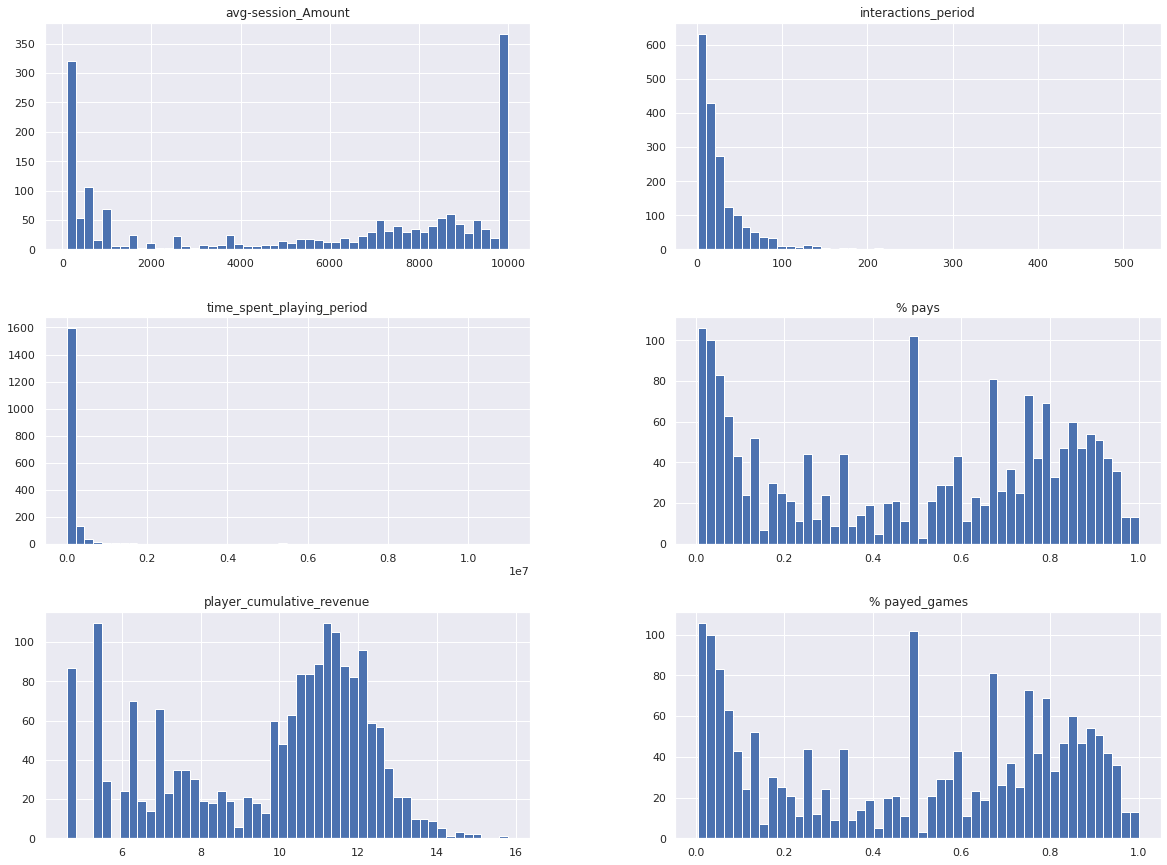

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20,15))
# pandas drop a column with drop function

plt.show()

In [ ]:
data is shewed to the left,  a lot of outliers to the right

Time and Revenue are correlated, it is interesting to see that some players pay nearly always while some almost never. The fact that there is a jump in the middle makes me thing that having a ^plaver typology would be interesting in order to separate the recency of the player that is causing that jump

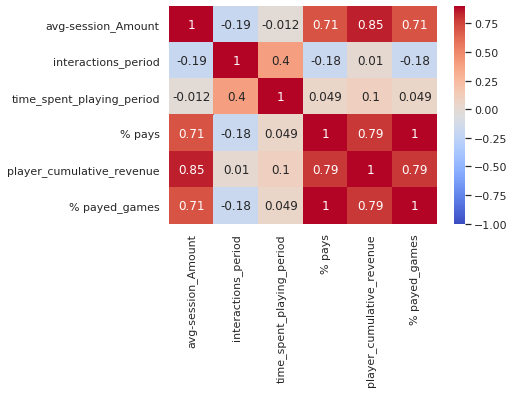

In [255]:

sns.set()
corrmat = X.corr()

sns.heatmap(corrmat, vmax=0.9,  square=False, vmin=-1,cmap='coolwarm',annot=True)


The TOT revenue is strongly correlated to the average amount spent on games and the nb of times that games are payed

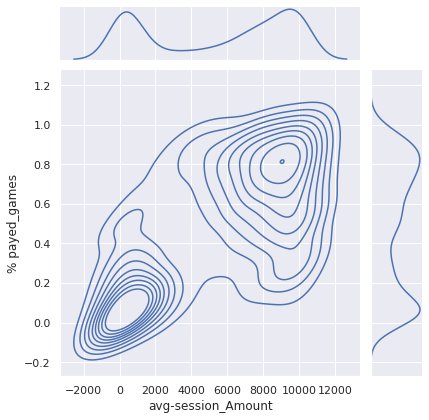

In [257]:
#Average session amount and % of games payed

g=sns.jointplot(x = 'avg-session_Amount', y = '% payed_games', data = X, kind = 'kde')

two groups, a group that barely payes anything (between 0 and 20% of games and a group that spends around 9000 and payes more then 70% of times

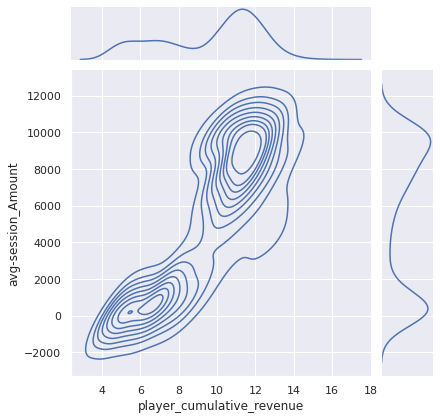

In [259]:
g=sns.jointplot(y = 'avg-session_Amount', x = 'player_cumulative_revenue', data = X, kind = 'kde')

# Predicting Variable: the group of people that are good payers and the bad payers
Normalizing the predicting variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


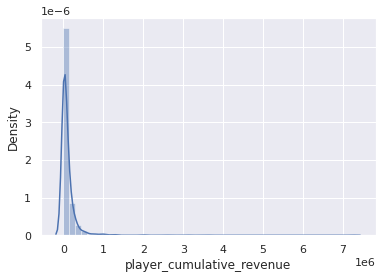

In [171]:
sns.set_style('darkgrid')
sns.distplot(player_dates['player_cumulative_revenue'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 107374.54 and sigma = 279989.11



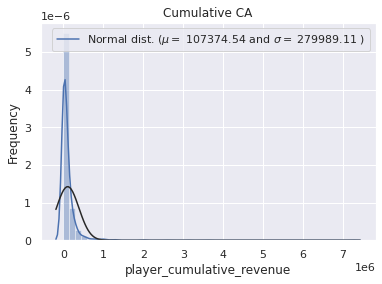

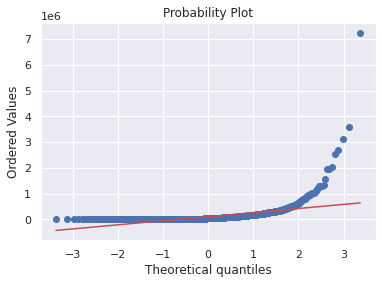

In [172]:
#Distribution of target variabe

from scipy import stats
from scipy.stats import norm, skew #for some statistics


#Check the new distribution 
sns.distplot(player_dates['player_cumulative_revenue'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(player_dates['player_cumulative_revenue'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Cumulative CA')

#Now plot the distribution



#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(player_dates['player_cumulative_revenue'], plot=plt)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 9.69 and sigma = 2.59



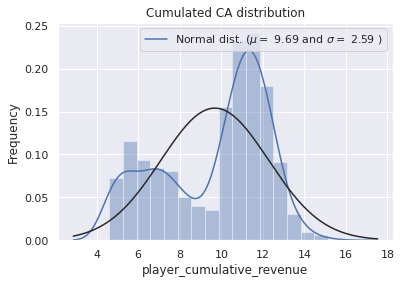

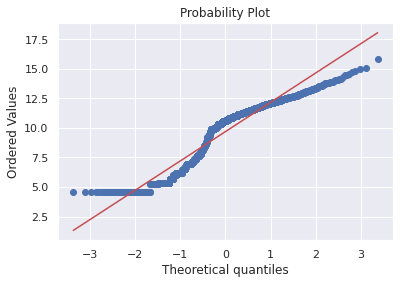

In [173]:
import numpy as np

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
player_dates['player_cumulative_revenue'] = np.log1p(player_dates['player_cumulative_revenue'])

#Check the new distribution 
sns.distplot(player_dates['player_cumulative_revenue'], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(player_dates['player_cumulative_revenue'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Cumulated CA distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(player_dates['player_cumulative_revenue'], plot=plt)
plt.show()

In [181]:
#creating label

player_dates["Class_Player"] = 'big'
player_dates.loc[player_dates['player_cumulative_revenue'] <= 9, 'Class_Player'] = 'low'


In [250]:
value9 = np.e**9 - 1
print(value9)

8102.08392757538


Big players spend more then 8102 pounds 

In [184]:
player_dates.groupby(['Class_Player'])[["avg-paying-session_Seconds","avg-session_Amount","interactions_period","time_spent_playing_period","% pays","player_cumulative_revenue"]].mean()

,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,% pays,player_cumulative_revenue
Class_Player,,,,,,
big,5029.595443,8085.044214,24.981636,153159.181135,0.672654,11.379145
low,6808.551976,558.503919,36.823248,119125.867834,0.138063,6.456385


In [264]:
player_dates.groupby(['Class_Player']).count()

,old_transaction_DATE,first_install_DATE,recent_transaction_DATE,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,paying_interactions,% pays,player_cumulative_revenue,% payed_games
Class_Player,,,,,,,,,,,
big,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198
low,628,628,628,628,628,628,628,628,628,628,628


In [261]:
value10 = np.e**11.379145 - 1
print(value10)

value11 = np.e**6.456385 - 1
print(value11)


87477.20888364552
635.7550215197211


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


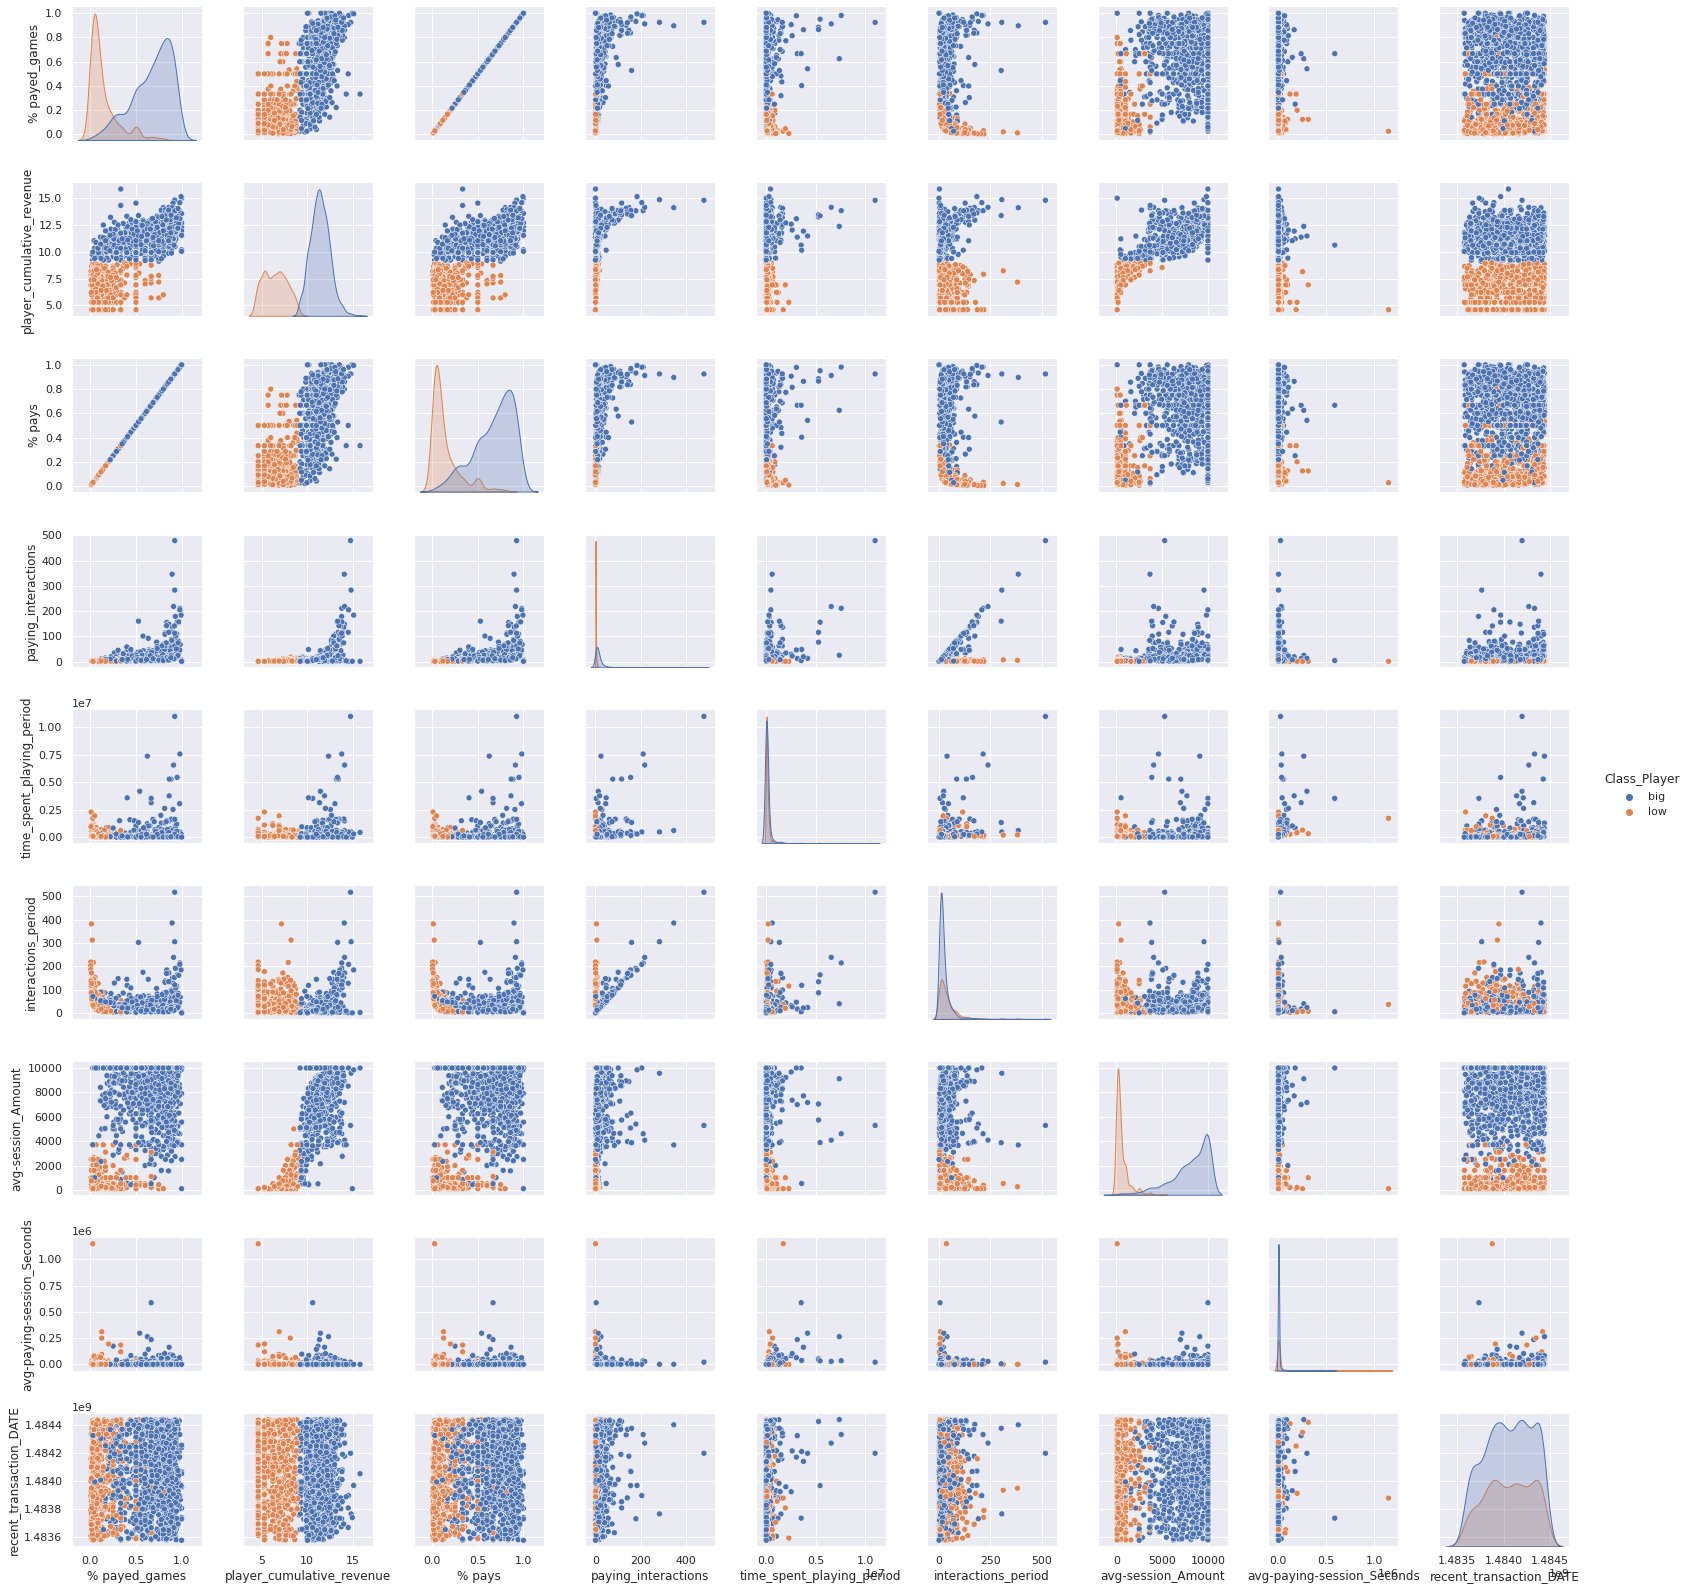

In [260]:
sns.pairplot(player_dates.iloc[:, [-1, -2, -3, -4, -5, -6 ,-7 ,-8, -9, -10]], hue='Class_Player',  size=2.5);
#we can see that prescribing more is positively correlated with all the other variables
#exception of emails webinar

# Modelling: KNeighbors, reaction on a look alike criteria

In [194]:


#player_dates["Class_Player"] = 'big'
#player_dates.loc[player_dates['player_cumulative_revenue'] <= 9, 'Class_Player'] = 'low'

# Train and valid samples
# only numeric variables for the clustering
y = player_dates['player_cumulative_revenue']
X = player_dates.drop(['player_cumulative_revenue',"Class_Player","old_transaction_DATE", "first_install_DATE", "recent_transaction_DATE","paying_interactions"],axis=1)
X.head()



,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,% pays
player_id,,,,,
0006fc5ec54e856d83762cccaddbeb37,199.000000,9999.000000,12,2617,0.333333
001d6c0b2a035550a3961ffa4e0b2db7,1905.290323,5518.354839,33,63096,0.939394
004375c61ee37f3c813738e340c84a90,96397.000000,999.000000,8,374434,0.125000
004c939c764359818e79cf038e01f927,2264.200000,9999.000000,13,26751,0.769231
00523c6b5e1a43d04d217868058ca589,268.000000,7239.000000,18,10617,0.277778


In [201]:
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
X_train, X_valid, Y_train, Y_valid = train_test_split(X, player_dates["Class_Player"], random_state = 0)

In [188]:
from scipy.spatial.distance import cdist
# ACP sur les var numériques
# l'ACP doit être appliqué sur des données standardisées
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

# on écrase et on standardise
X=StandardScaler().fit_transform(X)


In [196]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.neighbors import KNeighborsClassifier

In [205]:
#import class you plan to use
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)

#Fit the model with data (aka "model training")
knn.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [207]:
#predicting on test set
y_pred_test=knn.predict(X_valid)

In [215]:
#evaluating
from sklearn.metrics import accuracy_score, confusion_matrix

In [218]:
#evaluating
accuracy_score(Y_valid,y_pred_test)
confusion_matrix(Y_valid, y_pred_test)
stat=pd.DataFrame(list(map(lambda x:x/sum(x),confusion_matrix(Y_valid,y_pred_test))))
stat.head()

,0,1
0,0.980066,0.019934
1,0.179487,0.820513


In [219]:
print(accuracy_score(Y_valid,y_pred_test))

0.925601750547046


In [222]:
print(confusion_matrix(Y_valid, y_pred_test))

[[295   6]
 [ 28 128]]


The model correctly classifies 128 of the good clientes and misclassifies 6 of them into the bas clients group
The model incorrectly classifies 28 of the bad clients as good clients.


# Modelling XGboost

[0.01194459 0.9107538  0.02075068 0.01175065 0.04480028]


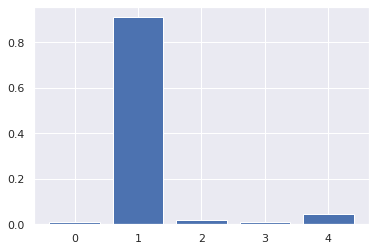

In [226]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X_train,Y_train)

#predicting on test set
#predicting on test set
y_pred_test=model.predict(X_valid)



In [227]:
#evaluating
accuracy_score(Y_valid,y_pred_test)
confusion_matrix(Y_valid, y_pred_test)
stat=pd.DataFrame(list(map(lambda x:x/sum(x),confusion_matrix(Y_valid,y_pred_test))))
stat.head()

,0,1
0,0.986711,0.013289
1,0.057692,0.942308


In [228]:
print(confusion_matrix(Y_valid, y_pred_test))

[[297   4]
 [  9 147]]


In [266]:
print(accuracy_score(Y_valid,y_pred_test))

0.9715536105032823


XG boost is much better at classificating the groups then KNN

[0.01194459 0.9107538  0.02075068 0.01175065 0.04480028]


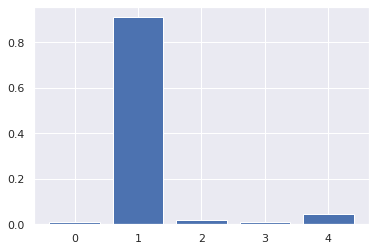

In [229]:
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [231]:
print(model.feature_names_)

AttributeError: ignored

In [232]:
X_train.head()

,avg-paying-session_Seconds,avg-session_Amount,interactions_period,time_spent_playing_period,% pays
player_id,,,,,
7d3f0538e894ac5652aec74d11db2c9b,716.000000,9999.000000,3,2148,0.666667
f598609359fccb261768ba3c332f51fa,761.000000,9999.000000,19,7083,0.315789
2084ebd1e0ed77a302eb4c2fdd9083cb,1864.666667,9299.000000,18,27169,0.500000
4d2eee366322bfbaf16d114095740918,4021.000000,5761.500000,9,36189,0.888889
a79dce0fe10aa602388ebae512d69685,3655.222222,3410.055556,25,82183,0.720000


In [233]:
pip freeze > requirements.txt